# House Prices Estimator

__Note:__ It's a competition from __Kaggle.com__ and the input data was retrieved from there.


## Data Analysis

In [141]:
import numpy as np
import pandas as pd

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test])

#size of training dataset
train_samples = train.shape[0]
test_samples = test.shape[0]

In [142]:
# remove the Id feature
data.drop(['Id'],1, inplace=True);

In [143]:
#data.describe()

In [144]:
datanum = data.select_dtypes([np.number])
datanum = datanum.fillna(datanum.dropna().mean())

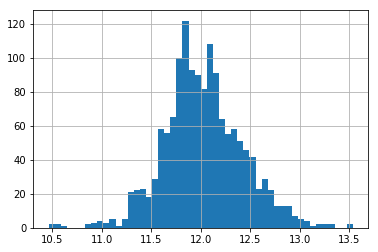

In [145]:
import matplotlib.pyplot as plt
%matplotlib inline
# Transforming to non-skewed SalePrice
data.SalePrice = data.SalePrice.apply(np.log)
data.SalePrice.hist(bins=50)

In [235]:
# Correlation features
datanum.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False).head(10)

OverallQual     0.547865
GrLivArea       0.518693
GarageCars      0.444010
GarageArea      0.437270
TotalBsmtSF     0.431030
1stFlrSF        0.421430
FullBath        0.394865
TotRmsAbvGrd    0.388821
YearBuilt       0.368417
YearRemodAdd    0.352833
Name: SalePrice, dtype: float64

In [238]:
def getDataWithHighCorrFeatures(data, numberFeatures=10):
    high_corr_feat_names = data.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False).head(numberFeatures).axes[0].tolist()
    #high_corr_feat_names.remove('SalePrice')
    return data[high_corr_feat_names]

### KFold

In [214]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=13)#, shuffle=True)
print(kf)

KFold(n_splits=10, random_state=13, shuffle=False)


In [188]:
#plotting PCA
from sklearn.decomposition import PCA

def getX_PCA(X):
    pca = PCA(n_components=1)
    return pca.fit(X).transform(X)
    
def plotPCA(X, y):
    pca = PCA(n_components=1)
    X_r = pca.fit(X).transform(X)
    plt.plot(X_r, y, 'x')

In [244]:
from sklearn.covariance import EllipticEnvelope

def removeAnomalies(X_train, y_train, verbose=False):
    # fit the model
    ee = EllipticEnvelope(contamination=0.01,
                          assume_centered=True,
                          random_state=13)
    ee.fit(X_train)
    pred = ee.predict(X_train)

    X_anom = X_train[pred != 1]
    y_anom = y_train[pred != 1]
    X_no_anom = X_train[pred == 1]
    y_no_anom = y_train[pred == 1]
    
    if (verbose):
        print("Number samples no anomalies: {}".format(X_no_anom.shape[0]))

    #after removing anomalies
    #plt.scatter(getX_PCA(X_no_anom), y_no_anom)
    #plt.scatter(getX_PCA(X_anom), y_anom)
    
    return X_no_anom, y_no_anom

### Model

In [246]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def train(X_train, y_train, verbose=False):
    lr = LinearRegression()

    #
    batch = 0
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        #training
        lr.fit(X_t, y_t)

        #calculate costs
        t_error = mean_squared_error(y_t, lr.predict(X_t))**0.5
        v_error = mean_squared_error(y_v, lr.predict(X_v))**0.5
        if verbose:
            print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
                  .format(batch, t_error, v_error, lr.score(X_v, y_v)))
        batch += 1
        
    return lr

def metrics(model, X, y, verbose=False):
    #Scores
    if verbose:
        print("Training score: {:.4f}".format(model.score(X, y)))
    #RMSLE
    rmsle = mean_squared_error(y, model.predict(X))**0.5
    if verbose:
        print("RMSLE: {:.4f}".format(rmsle))
        # Plotting the results
        plt.scatter(model.predict(X), y)
        
    return rmsle

In [209]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

def getPolynomial(X_train, X_no_anom, X_test):
    poly = PolynomialFeatures(degree=2)
    return poly.fit_transform(X_train), poly.fit_transform(X_no_anom), poly.fit_transform(X_test)

In [248]:
def getKeyWithMinError(X_train, X_no_amon, y_train, y_no_anom, verbose=False):
    rmsles = {}
    for f in range(1,X_train.shape[1]):
        model = train(X_no_anom[:,:f], y_no_anom, verbose=False)
        rmsles[f] = metrics(model, X_train[:,:f], y_train, verbose=False)

    min_error_key = min(rmsles, key=rmsles.get)
    
    if (verbose):
        print("Min error (k={}):{}".format(min_error_key, rmsles[min_error_key]))
    #model = train(X_train_pol[:,:min_error_key], y_train)
    #metrics(model, X_train_orig_pol[:,:min_error_key], y_train_orig)
    #pd.Series(rmsles).plot()
    return min_error_key


## Running Models

f:1 err:0.230
f:2 err:0.205
f:3 err:0.182
f:4 err:0.178
f:5 err:0.164
f:6 err:0.163
f:7 err:0.162
f:8 err:0.161
f:9 err:0.153
f:10 err:0.145
f:11 err:0.145
f:12 err:0.139
f:13 err:0.139
f:14 err:0.132
f:15 err:0.130
f:16 err:0.138


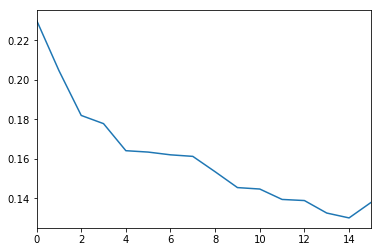

In [253]:
import warnings
warnings.filterwarnings('ignore')

errors = []
for f in range(1,17):
    #print("====Corr feat: {}====".format(f))
    datanum_high_corr = getDataWithHighCorrFeatures(datanum, f)

    y = np.array(data['SalePrice'])
    X = np.array(datanum_high_corr)

    #split by idx
    idx = train_samples
    X_train, X_test = X[:idx], X[idx:]
    y_train, y_test = y[:idx], y[idx:]

    #print("Shape X train: {}".format(X_train.shape))

    X_no_anom, y_no_anom = removeAnomalies(X_train, y_train)
    #print("Shape X train (no anom): {}".format(X_no_anom.shape))

    X_train, X_no_anom, X_test = getPolynomial(X_train, X_no_anom, X_test)
    #print("Shape X train (poly): {}".format(X_no_anom.shape))

    key = getKeyWithMinError(X_train, X_no_anom, y_train, y_no_anom)
    model = train(X_no_anom[:,:key], y_no_anom)
    error = metrics(model, X_train[:,:key], y_train)
    
    print("f:{} err:{:.3f}".format(f, error))
    errors.append(error)

# show graph
pd.Series(errors).plot()

## Get Predictions

In [258]:
import os

datanum_high_corr = getDataWithHighCorrFeatures(datanum, 15)
y = np.array(data['SalePrice'])
X = np.array(datanum_high_corr)

#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

X_no_anom, y_no_anom = removeAnomalies(X_train, y_train)
X_train, X_no_anom, X_test = getPolynomial(X_train, X_no_anom, X_test)
key = getKeyWithMinError(X_train, X_no_anom, y_train, y_no_anom)
model = train(X_no_anom[:,:key], y_no_anom)
error = metrics(model, X_train[:,:key], y_train)
print(error)

predict = model.predict(X_test[:,:key])

#predictions are logs, return to the value
predict = np.exp(predict)

file = "Id,SalePrice" + os.linesep

startId = 1461
for i in range(len(X_test)):
    file += "{},{}".format(startId, (int)(predict[i])) + os.linesep
    startId += 1

#print(file)

0.13001519905


In [259]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)